# Data Set

In [ ]:
import os
import shutil
from abc import *
import sentencepiece as spm
import torch
from torch.utils.data import Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def create_or_get_voca(save_path, ko_corpus_path=None, en_corpus_path=None, ko_vocab_size=5000, en_vocab_size=5000):
    ko_corpus_prefix = 'ko_corpus_5000'        # vocab_size를 바꾸면 embedding_size도 변경
    en_corpus_prefix = 'en_corpus_5000'

    if ko_corpus_path and en_corpus_path:
        templates = '--input={} --model_prefix={} --vocab_size={} ' \
                    '--bos_id=0 --eos_id=1 --unk_id=2 --pad_id=3'
        # input : 학습시킬 텍스트의 위치
        # model_prefix : 만들어질 모델 이름
        # vocab_size : 사전의 크기
        ko_model_train_cmd = templates.format(ko_corpus_path, ko_corpus_prefix, ko_vocab_size)
        en_model_train_cmd = templates.format(en_corpus_path, en_corpus_prefix, en_vocab_size)

        spm.SentencePieceTrainer.Train(ko_model_train_cmd)  # Korean 텍스트를 가지고 학습
        spm.SentencePieceTrainer.Train(en_model_train_cmd)  # English 텍스트를 가지고 학습

        # 파일을 저장위치로 이동
        shutil.move(ko_corpus_prefix + '.model', save_path)
        shutil.move(ko_corpus_prefix + '.vocab', save_path)
        shutil.move(en_corpus_prefix + '.model', save_path)
        shutil.move(en_corpus_prefix + '.vocab', save_path)

    ko_sp = spm.SentencePieceProcessor()
    en_sp = spm.SentencePieceProcessor()
    ko_sp.load(os.path.join(save_path, ko_corpus_prefix+'.model'))  # model load
    en_sp.load(os.path.join(save_path, en_corpus_prefix+'.model'))  # model load
    return ko_sp, en_sp

- Vocabulary를 만드는 함수
- 기존 Tokenizer
    - 단어 개수에 비례하여 계산비용이 증가한다
    - 만약 계산비용을 감소시키기 위해 개수를 제한한다면 미등록 단어가 발생한다.
- 이를 보완한 것이 Word Piece Model
    - 단어를 표현할 수 있는 subwords units으로 모든 단어를 표현
    - 모든 단어의 시작에는 underbar를 붙임
    - 그 중 2018년 구글에서 공개한 WPM인 Sentence piece를 사용할 것이다.
- 여러 가지 vocab size 중 실험하여 5000을 선택

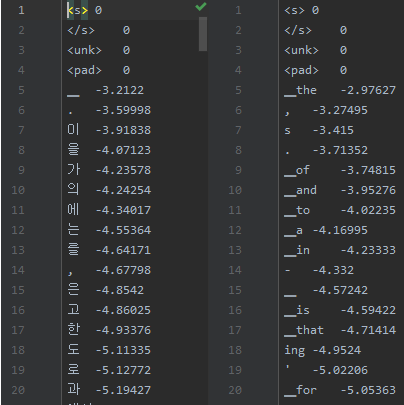

In [ ]:
class TranslationDataset(Dataset, metaclass=ABCMeta):
    # Translation Dataset abstract class
    # download, read data 등등을 하는 파트.
    def __init__(self, x_path, y_path, ko_voc, en_voc, sequence_size):
        self.x = open(x_path, 'r', encoding='utf-8').readlines()        # korean data 위치
        self.y = open(y_path, 'r', encoding='utf-8').readlines()        # English data 위치
        self.ko_voc = ko_voc                                            # Korean 사전
        self.en_voc = en_voc                                            # English 사전
        self.sequence_size = sequence_size                              # sequence 최대길이

    def __len__(self):  # data size를 넘겨주는 파트
        if len(self.x) != len(self.y):
            raise IndexError('not equal x_path, y_path line size')
        return len(self.x)

    @abstractmethod
    def encoder_input_to_vector(self, sentence: str): pass

    @abstractmethod
    def decoder_input_to_vector(self, sentence: str): pass

    @abstractmethod
    def decoder_output_to_vector(self, sentence: str): pass


class LSTMSeq2SeqDataset(TranslationDataset):
    # for Seq2Seq model & Seq2Seq attention model
    # using google sentencepiece (https://github.com/google/sentencepiece.git)
    def __init__(self, x_path, y_path, ko_voc, en_voc, sequence_size):
        super().__init__(x_path, y_path, ko_voc, en_voc, sequence_size)
        self.KO_PAD_ID = ko_voc['<pad>']    # 3 Padding
        self.EN_PAD_ID = en_voc['<pad>']    # 3 Padding
        self.EN_BOS_ID = en_voc['<s>']      # 0 Start Token
        self.EN_EOS_ID = en_voc['</s>']     # 1 End Token

    def __getitem__(self, idx):
        encoder_input = self.encoder_input_to_vector(self.x[idx])
        decoder_input = self.decoder_input_to_vector(self.y[idx])
        decoder_output = self.decoder_output_to_vector(self.y[idx])
        return encoder_input, decoder_input, decoder_output

    def encoder_input_to_vector(self, sentence: str):
        idx_list = self.ko_voc.EncodeAsIds(sentence)    # str -> idx
        idx_list = self.padding(idx_list, self.KO_PAD_ID)   # padding 삽입
        return torch.tensor(idx_list).to(device)

    def decoder_input_to_vector(self, sentence: str):
        idx_list = self.en_voc.EncodeAsIds(sentence)        # str -> idx
        idx_list.insert(0, self.EN_BOS_ID)                  # Start Token 삽입
        idx_list = self.padding(idx_list, self.EN_PAD_ID)   # padding 삽입
        return torch.tensor(idx_list).to(device)

    def decoder_output_to_vector(self, sentence: str):
        idx_list = self.en_voc.EncodeAsIds(sentence)        # str -> idx
        idx_list.append(self.EN_EOS_ID)                     # End Token 삽입
        idx_list = self.padding(idx_list, self.EN_PAD_ID)   # padding 삽입
        return torch.tensor(idx_list).to(device)

    def padding(self, idx_list, padding_id):
        length = len(idx_list)  # 리스트의 길이
        if length < self.sequence_size:
            # sentence가 sequence_size가 작으면 나머지를 padding token으로 채움
            idx_list = idx_list + [padding_id for _ in range(self.sequence_size - len(idx_list))]
        else:
            idx_list = idx_list[:self.sequence_size]
        return idx_list

- dataset을 만들어주는 함수
- Start Token을 < s >로, End Token
- < /s >로 설정, padding Token <pad>로 설정
    
- EncodeAsIds(sentence) : 문장을 넣으면 해당 vocab에서 id를 찾아서 리턴
<br><br>
- Encoder Input 에는 따로 Start token이나 End Token을 붙여주지 않고
- Decoder Input에는 start Token을 삽입
- Decoder output에는 End Token을 삽입 